##Muhammad Zaki
###Kota Bukittinggi,
muhammadzaki476@gmail.com

In [1]:
!wget --no-check-certificate \
  https://github.com//kaniang/timeSeries_weatherDataSets/raw/main/weatherHistory.csv.zip\
  -O /content/archive.zip

--2021-10-16 09:25:00--  https://github.com//kaniang/timeSeries_weatherDataSets/raw/main/weatherHistory.csv.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kaniang/timeSeries_weatherDataSets/main/weatherHistory.csv.zip [following]
--2021-10-16 09:25:01--  https://raw.githubusercontent.com/kaniang/timeSeries_weatherDataSets/main/weatherHistory.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2342555 (2.2M) [application/zip]
Saving to: ‘/content/archive.zip’

/content/archive.zi 100%[===================>]   2.23M  --.-KB/s    in 0.06s   

2021-10-16 09:25:01 (35.4 MB/s) - ‘/content/arch

In [2]:
import zipfile,os
local_zip = '/content/archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [4]:
data = pd.read_csv('weatherHistory.csv')
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [5]:
list_of_cols_to_change = ['Formatted Date']
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'],utc=True)

In [6]:
def datefunc_new(column):
    data[column] = data[column].dt.date

map(datefunc_new, list_of_cols_to_change)
def to_date(series):
    return series.dt.date

data[list_of_cols_to_change] = data[list_of_cols_to_change].apply(to_date)

In [7]:
data.tail()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
96448,2016-09-09,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.
96452,2016-09-09,Partly Cloudy,rain,20.438889,20.438889,0.61,5.8765,39.0,15.5204,0.0,1016.16,Partly cloudy starting in the morning.


In [8]:
drop_kolom = data.drop(columns=['Summary', 'Precip Type', 'Apparent Temperature (C)', 'Humidity','Wind Speed (km/h)','Wind Bearing (degrees)','Visibility (km)','Loud Cover','Pressure (millibars)','Daily Summary'])
drop_kolom.tail()

,Formatted Date,Temperature (C)
96448,2016-09-09,26.016667
96449,2016-09-09,24.583333
96450,2016-09-09,22.038889
96451,2016-09-09,21.522222
96452,2016-09-09,20.438889


In [9]:
data_drop = drop_kolom.drop_duplicates('Formatted Date',keep='first')

In [10]:
df = data_drop.sort_values(['Formatted Date'], ascending= True)
df

,Formatted Date,Temperature (C)
2880,2005-12-31,0.577778
2881,2006-01-01,1.161111
3145,2006-01-02,2.350000
3409,2006-01-03,1.733333
3481,2006-01-04,1.700000
...,...,...
89590,2016-12-27,-0.966667
89614,2016-12-28,-1.016667
89638,2016-12-29,-1.066667
89686,2016-12-30,-1.116667


In [11]:
dates = df['Formatted Date'].values
temp  = df['Temperature (C)'].values

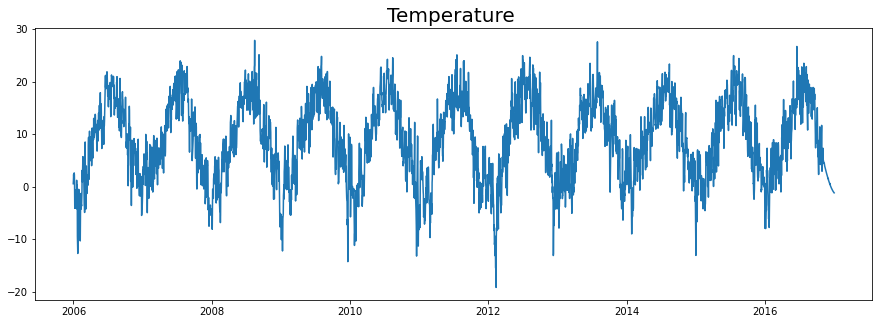

In [12]:
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature ',
          fontsize=20);

In [13]:
temp = temp.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
temp_scaled = scaler.fit_transform(temp)
temp_scaled

array([[0.41984643],
       [0.43225044],
       [0.45753101],
       ...,
       [0.38487891],
       [0.38381571],
       [0.38287064]])

In [14]:
x_train, x_test, y_train, y_test = train_test_split(dates, temp_scaled, test_size=0.2,shuffle=False)
y_train.shape 

(3215, 1)

In [15]:
y_test.shape

(804, 1)

In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds= ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size +1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [17]:
class callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch, logs={}):
    if(logs.get('mae')<0.1):
      print('target akurasi terpenuhi')
      self.model.stop_training = True
cb = callback()

In [18]:
train_set = windowed_dataset(y_train, window_size=200, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(y_test, window_size=200, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=100, kernel_size=100, strides=2, padding="causal", activation="relu",input_shape=[None, 1]),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(1)
])

In [19]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500, callbacks=cb, validation_data = val_set, batch_size=100)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
      5/Unknown - 33s 53ms/step - loss: 0.1762 - mae: 0.5698WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0243s vs `on_train_batch_end` time: 0.0243s). Check your callbacks.
31/31 [==============================] - 35s 74ms/step - loss: 0.1662 - mae: 0.5490 - val_loss: 0.1485 - val_mae: 0.5205
Epoch 2/500
31/31 [==============================] - 2s 52ms/step - loss: 0.1275 - mae: 0.4669 - val_loss: 0.1073 - val_mae: 0.4307
Epoch 3/500
31/31 [==============================] - 2s 53ms/step - loss: 0.1017 - mae: 0.4030 - val_loss: 0.0826 - val_mae: 0.3664
Epoch 4/500
31/31 [==============================] - 2s 54ms/step - loss: 0.0870 - mae: 0.3648 - val_loss: 0.0672 - val_mae: 0.3212
Epoch 5/500
31/31 [==============================] - 2s 55ms/step - loss: 0.0779 - mae: 0.3402 - val_loss: 0.0573 - val_mae: 0.2897
Epoch 6/500
31/31 [==============================] - 2s 55ms/step - loss: 0.0722 - mae: 0.3249 - val_loss

In [20]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500, callbacks=cb, validation_data = val_set, batch_size=100)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
31/31 [==============================] - 5s 71ms/step - loss: 0.0110 - mae: 0.1208 - val_loss: 0.0092 - val_mae: 0.1151
Epoch 2/500
31/31 [==============================] - 2s 55ms/step - loss: 0.0110 - mae: 0.1208 - val_loss: 0.0092 - val_mae: 0.1151
Epoch 3/500
31/31 [==============================] - 2s 52ms/step - loss: 0.0110 - mae: 0.1207 - val_loss: 0.0092 - val_mae: 0.1150
Epoch 4/500
31/31 [==============================] - 2s 53ms/step - loss: 0.0110 - mae: 0.1208 - val_loss: 0.0092 - val_mae: 0.1150
Epoch 5/500
31/31 [==============================] - 2s 53ms/step - loss: 0.0110 - mae: 0.1206 - val_loss: 0.0091 - val_mae: 0.1148
Epoch 6/500
31/31 [==============================] - 2s 55ms/step - loss: 0.0110 - mae: 0.1205 - val_loss: 0.0091 - val_mae: 0.1148
Epoch 7/500
31/31 [==============================] - 2s 54ms/step - loss: 0.0110 - mae: 0.1207 - val_loss: 0.0091 - val_mae: 0.1148
Epoch 8/500
31/31 [==============================] - 2s 52ms/step - loss: 0.

In [21]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500, callbacks=cb, validation_data = val_set, batch_size=100)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
      5/Unknown - 3s 51ms/step - loss: 0.0082 - mae: 0.1034WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0234s vs `on_train_batch_end` time: 0.0266s). Check your callbacks.
31/31 [==============================] - 5s 69ms/step - loss: 0.0092 - mae: 0.1091 - val_loss: 0.0070 - val_mae: 0.0989
Epoch 2/500
31/31 [==============================] - 2s 53ms/step - loss: 0.0092 - mae: 0.1090 - val_loss: 0.0070 - val_mae: 0.0989
Epoch 3/500
31/31 [==============================] - 2s 51ms/step - loss: 0.0092 - mae: 0.1090 - val_loss: 0.0070 - val_mae: 0.0988
Epoch 4/500
31/31 [==============================] - 2s 52ms/step - loss: 0.0092 - mae: 0.1090 - val_loss: 0.0070 - val_mae: 0.0988
Epoch 5/500
31/31 [==============================] - 2s 56ms/step - loss: 0.0091 - mae: 0.1087 - val_loss: 0.0070 - val_mae: 0.0988
Epoch 6/500
31/31 [==============================] - 2s 53ms/step - loss: 0.0092 - mae: 0.1089 - val_loss: 

In [22]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500, callbacks=cb, validation_data = val_set, batch_size=100)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
      6/Unknown - 3s 50ms/step - loss: 0.0076 - mae: 0.0995WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0250s vs `on_train_batch_end` time: 0.0262s). Check your callbacks.
31/31 [==============================] - 5s 67ms/step - loss: 0.0083 - mae: 0.1032 - val_loss: 0.0059 - val_mae: 0.0898
Epoch 2/500
31/31 [==============================] - 2s 53ms/step - loss: 0.0083 - mae: 0.1031 - val_loss: 0.0059 - val_mae: 0.0898
Epoch 3/500
31/31 [==============================] - 2s 55ms/step - loss: 0.0083 - mae: 0.1030 - val_loss: 0.0059 - val_mae: 0.0898
Epoch 4/500
31/31 [==============================] - 2s 53ms/step - loss: 0.0083 - mae: 0.1031 - val_loss: 0.0059 - val_mae: 0.0897
Epoch 5/500
31/31 [==============================] - 2s 55ms/step - loss: 0.0083 - mae: 0.1030 - val_loss: 0.0059 - val_mae: 0.0897
Epoch 6/500
31/31 [==============================] - 2s 52ms/step - loss: 0.0083 - mae: 0.1031 - val_loss: 

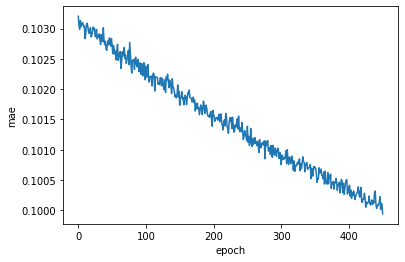

In [23]:
plt.plot(history.history['mae'])
plt.xlabel('epoch')
plt.ylabel('mae')
plt.show()

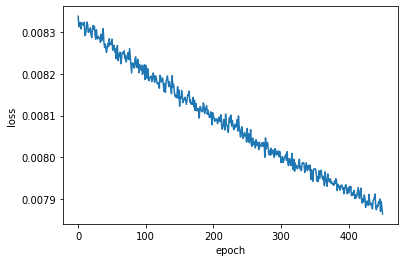

In [24]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [25]:
mae =  max(temp)-min(temp)
minimal_mae = mae*0.1
minimal_mae

array([4.70277778])